In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [15]:
import configparser
from dataset import Dataset
import tensorflow as tf

In [6]:
config = configparser.ConfigParser()
config.read("config.ini")

DATASET_PATH = str(config["DEFAULT"]["DATASET_PATH" ])

In [7]:
ds = Dataset(folder_path=DATASET_PATH, mem_length=1024)
ds.update_dataset(batch_size=1024)

dataset is loading please wait...
dataset is loaded.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
dataset is updated :  1024


In [31]:
xis, xjs = ds.next_batch(batch_size=256)

In [32]:
sample_image = xis[0].numpy()
print(sample_image.shape)

(128, 128, 1)


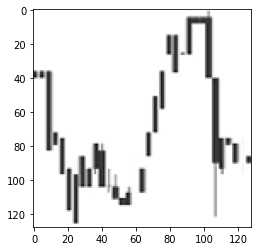

In [33]:
plt.imshow(np.reshape(sample_image, (128, 128)), cmap="gray")

In [16]:
class ConvolutionalLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape=None, output_features=None, name=None):
        super(ConvolutionalLayer, self).__init__(name=name)
        self.conv_1          = tf.keras.layers.Conv2D(
                32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)
        self.maxpooling_1    = tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=2)
        self.conv_2          = tf.keras.layers.Conv2D(
                64, kernel_size=(3, 3), activation='relu')
        self.normalization_1 = tf.keras.layers.BatchNormalization()
        self.maxpooling_2    = tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=2)
        self.conv_3          = tf.keras.layers.Conv2D(
                128, kernel_size=(3, 3), activation='relu')
        self.maxpooling_3    = tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=2)
        self.averagepooling  = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer    = tf.keras.layers.Dense(output_features)
    def call(self, inputs, training=False):
        x = self.conv_1(inputs)
        x = self.maxpooling_1(x)
        x = self.conv_2(x)
        x = self.normalization_1(x)
        x = self.maxpooling_2(x)
        x = self.conv_3(x)
        x = self.maxpooling_3(x)
        x = self.averagepooling(x)
        return self.output_layer(x)

class SimCLR(tf.keras.Model):
    def __init__(self,):
        super(SimCLR, self).__init__()
        self.conv_layer   = ConvolutionalLayer(
                #input_shape=(256, 256, 3),
                input_shape=(128, 128, 1),
                output_features=128,
                name="convolutional_features")
        self.projection_1 = tf.keras.layers.Dense(256, activation='relu')
        self.projection_2 = tf.keras.layers.Dense(128, activation='relu')
        self.z_layer      = tf.keras.layers.Dense(64)
    def call(self, inputs, training=False):
        x = self.conv_layer(inputs)
        x = self.projection_1(x)
        x = self.projection_2(x)
        return self.z_layer(x)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

simclr_model = SimCLR()

ckpt = tf.train.Checkpoint(
        step=tf.Variable(1),
        optimizer=optimizer,
        net=simclr_model
        )
ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints', max_to_keep=3)
ckpt.restore(ckpt_manager.latest_checkpoint)

if ckpt_manager.latest_checkpoint:
    print("Latest weights restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing weights from scratch")

Latest weights restored from ./checkpoints\ckpt-36


In [19]:
conv_layer = simclr_model.get_layer('convolutional_features')

In [34]:
features_list = conv_layer(tf.convert_to_tensor(xis))

In [35]:
features_list[0].shape

TensorShape([128])

In [36]:
tsne = TSNE(n_components=2, perplexity=40.0)

In [37]:
tsne_result = tsne.fit_transform(features_list.numpy())

In [38]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [39]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(128, 128), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [42]:
visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (128, 128)) for i in xis], image_zoom=1.2)